In [1]:
# this code is used for revise everything to make it easier for evalution.
# check if +1, -1 works well here.
# updated date: 20240204 19:35

In [2]:
import random

import numpy as np
import torch
import matplotlib.pyplot as plt

from models import EdgeNetAndRejector, LocalNet
from dataset import load_data

# dataset pre-prossessing
Batch_size=16
Batch_size_test=16
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(f"Using {device} device")

Using cuda device


In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [4]:
trainset_full, testset_full = load_data("cifar10")

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset_full, batch_size=Batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_full, batch_size=Batch_size_test, shuffle=False, num_workers=2)

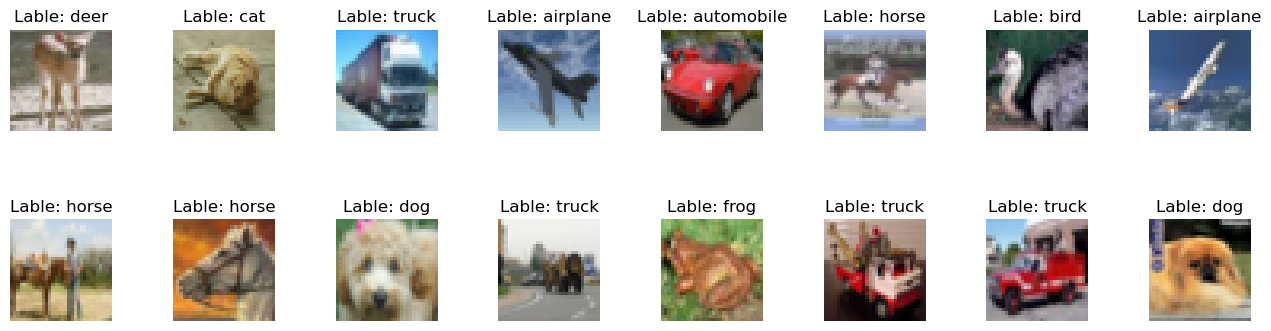

In [6]:
# print 16 images in two rows grid
def show_images(classes, images, labels, pred_labels=None):
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    for i, ax in enumerate(axes.flat):
        image, label = images[i], classes[labels[i]]
        if pred_labels is not None:
            label += f'\n Pred: {classes[pred_labels[i]]}'
        ax.imshow((image.permute(1, 2, 0) + 1) / 2)
        ax.title.set_text(f'Lable: {label}')
        ax.axis('off')

    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(trainset_full.classes, images, labels)

In [7]:
print(trainset_full[0][0].size())

torch.Size([3, 32, 32])


In [8]:
mobile_net = LocalNet(len(trainset_full.classes)).to(device)
mobile_net.load_state_dict(torch.load('cifar-localnet.pth'))
mobile_net.eval();

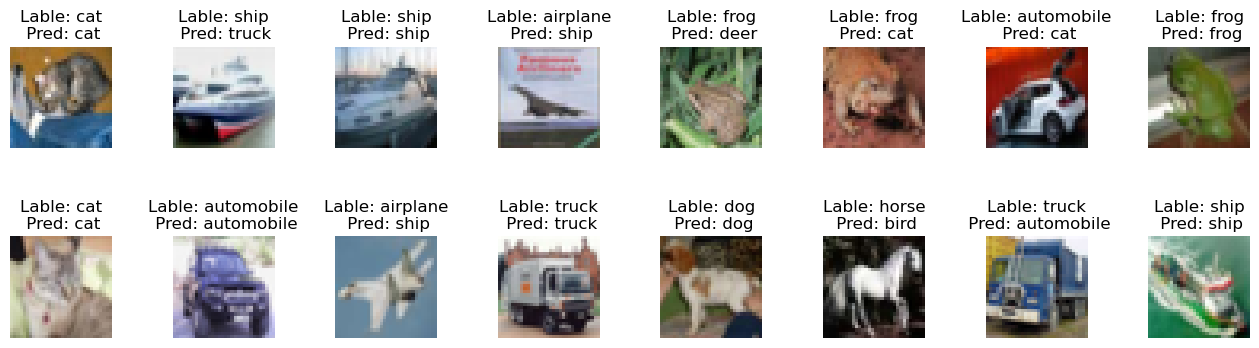

In [9]:
# testing
dataiter = iter(testloader)
images, labels = next(dataiter)
pred_labels = torch.argmax(mobile_net(images.to(device)), dim=1)

show_images(testset_full.classes, images, labels, pred_labels)

In [10]:
# need batch size > 1  done
correct = 0
total = 0
labels_map = {i: [0, 0] for i in range(len(testset_full.classes))}

with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        outputs = mobile_net(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i, label in enumerate(labels):
            labels_map[label.item()][1] += 1
            if label == predicted[i]:
                labels_map[label.item()][0] += 1

print("Sample size: ", total)
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
print('Accuracy for each class:')
for i, class_name in enumerate(testset_full.classes):
    print(f'{class_name}: {labels_map[i][0] / labels_map[i][1] * 100:.2f}%')

Sample size:  10000
Accuracy of the network on test images: 38 %
Accuracy for each class:
airplane: 51.30%
automobile: 45.00%
bird: 23.40%
cat: 20.80%
deer: 30.80%
dog: 36.40%
frog: 43.70%
horse: 37.10%
ship: 53.60%
truck: 45.20%


Now we have fixed local classifier. Let's build the mobile-edge-cloud system.

In [11]:
# Define the edge model
edge_net = EdgeNetAndRejector(len(trainset_full.classes)).to(device)
edge_net.load_state_dict(torch.load('cifar-edgenet-cost_1-1.2-cost_e-0.2.pth'))
edge_net.eval();

In [12]:
# only run on edge
correct = 0
total = 0
labels_map = {i: [0, 0] for i in range(len(testset_full.classes))}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        mobile_outputs = mobile_net(images)
        edge_outputs = edge_net(images)
        r, e = edge_outputs[0].to(device), edge_outputs[1].to(device)

        predicted = torch.argmax(e, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i, label in enumerate(labels):
            labels_map[label.item()][1] += 1
            if label == predicted[i]:
                labels_map[label.item()][0] += 1

print("Sample size: ", total)
print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
print('Accuracy for each class:')
for i, class_name in enumerate(testset_full.classes):
    print(f'{class_name}: {labels_map[i][0] / labels_map[i][1] * 100:.2f}%')

Sample size:  10000
Accuracy of the network on test images: 60 %
Accuracy for each class:
airplane: 62.00%
automobile: 74.70%
bird: 46.80%
cat: 29.70%
deer: 65.00%
dog: 46.20%
frog: 67.20%
horse: 64.60%
ship: 77.90%
truck: 66.90%


In [13]:
correct = 0
total = 0
predict_locally = 0
predict_remotely = 0
# local_correct, local_total, remote_correct, remote_total
labels_map = {i: [0, 0, 0, 0] for i in range(len(testset_full.classes))}
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        edge_outputs = edge_net(images)
        mobile_outputs = mobile_net(images).to(device)
        r, e = edge_outputs[0].to(device), edge_outputs[1].to(device)

        is_remote = torch.argmax(r, dim=1)
        predict_remotely += is_remote.sum().item()
        predict_locally += (1-is_remote).sum().item()

        predicted = mobile_outputs*(1-is_remote.unsqueeze(1)) + e*is_remote.unsqueeze(1)
        predicted = torch.argmax(predicted, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i, label in enumerate(labels):
            if is_remote[i] == 0:
                labels_map[label.item()][1] += 1
                if label == predicted[i]:
                    labels_map[label.item()][0] += 1
            else:
                labels_map[label.item()][3] += 1
                if label == predicted[i]:
                    labels_map[label.item()][2] += 1

print('Sample size: %d' %total)
print(f"Decision made locally: {predict_locally}")
print(f"Decision made on edge: {predict_remotely}")

print('Accuracy of the network on test images: %d%%' % (
    100 * correct / total))
print('Accuracy for each class:')
for i, class_name in enumerate(testset_full.classes):
    print(
        f'{class_name}:\n\t'
        f'Local Total: {labels_map[i][1]}, Edge Total: {labels_map[i][3]}\n'
        f"\tLocal: {labels_map[i][0] / labels_map[i][1] * 100:.2f}%, "
        f"Edge: {labels_map[i][2] / labels_map[i][3] * 100:.2f}%, "
        f"Overall: {(labels_map[i][0] + labels_map[i][2]) / (labels_map[i][1] + labels_map[i][3]) * 100:.2f}%"
    )

Sample size: 10000
Decision made locally: 806
Decision made on edge: 9194
Accuracy of the network on test images: 59%
Accuracy for each class:
airplane:
	Edge Total: 158, Remote Total: 842
	Edge: 75.32%, Remote: 59.26%, Overall: 61.80%
automobile:
	Edge Total: 133, Remote Total: 867
	Edge: 67.67%, Remote: 73.47%, Overall: 72.70%
bird:
	Edge Total: 27, Remote Total: 973
	Edge: 7.41%, Remote: 47.17%, Overall: 46.10%
cat:
	Edge Total: 33, Remote Total: 967
	Edge: 24.24%, Remote: 29.99%, Overall: 29.80%
deer:
	Edge Total: 21, Remote Total: 979
	Edge: 38.10%, Remote: 64.96%, Overall: 64.40%
dog:
	Edge Total: 35, Remote Total: 965
	Edge: 42.86%, Remote: 45.80%, Overall: 45.70%
frog:
	Edge Total: 61, Remote Total: 939
	Edge: 80.33%, Remote: 66.45%, Overall: 67.30%
horse:
	Edge Total: 84, Remote Total: 916
	Edge: 69.05%, Remote: 62.34%, Overall: 62.90%
ship:
	Edge Total: 134, Remote Total: 866
	Edge: 73.88%, Remote: 76.44%, Overall: 76.10%
truck:
	Edge Total: 120, Remote Total: 880
	Edge: 64.1

In [14]:
# Experiment 2: different rejection rate
rejection_rate_results = {}
for rejection_rate in np.arange(0, 1, 0.05):
    correct = 0
    total = 0
    predict_locally = 0
    predict_remotely = 0
    # local_correct, local_total, remote_correct, remote_total
    labels_map = {i: [0, 0, 0, 0] for i in range(len(testset_full.classes))}
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device),data[1].to(device)
            edge_outputs = edge_net(images)
            mobile_outputs = mobile_net(images).to(device)
            r, e = edge_outputs[0].to(device), edge_outputs[1].to(device)

            # ------- This is the start of the modification -------
            # 0: local, 1: remote
            r = torch.nn.functional.softmax(r, dim=1)
            is_remote = (r[:, 1] < rejection_rate).type(torch.int)
            # ------- This is the end of the modification -------
            predict_remotely += is_remote.sum().item()
            predict_locally += (1-is_remote).sum().item()

            predicted = mobile_outputs*(1-is_remote.unsqueeze(1)) + e*is_remote.unsqueeze(1)
            predicted = torch.argmax(predicted, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i, label in enumerate(labels):
                if is_remote[i] == 0:
                    labels_map[label.item()][1] += 1
                    if label == predicted[i]:
                        labels_map[label.item()][0] += 1
                else:
                    labels_map[label.item()][3] += 1
                    if label == predicted[i]:
                        labels_map[label.item()][2] += 1

    rejection_rate_results[rejection_rate] = {
        "total": total,
        "correct": correct,
        "labels_map": labels_map,
        "predict_locally": predict_locally,
        "predict_remotely": predict_remotely,
    }

In [15]:
import json

with open("rejection_rate_results.json", "w") as f:
    json.dump(rejection_rate_results, f, indent=2)

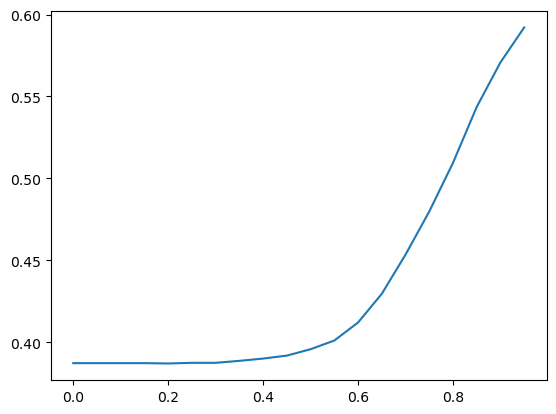

In [16]:
plt.plot(rejection_rate_results.keys(), [result["correct"] / result["total"] for result in rejection_rate_results.values()])

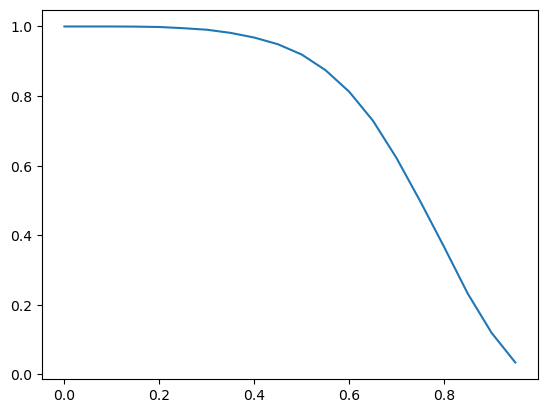

In [17]:
plt.plot(rejection_rate_results.keys(), [result["predict_locally"] / result["total"] for result in rejection_rate_results.values()])

In [18]:
# Experiment 7: The test accuracy of rejected data on mobile classifier and test accuracy of non-rejected data on server classifier.
# We use some hack: send the rejected data to the mobile classifier and non-rejected data to the server classifier.

correct = 0
total = 0
predict_locally = 0
predict_remotely = 0
# local_correct, local_total, remote_correct, remote_total
labels_map = {i: [0, 0, 0, 0] for i in range(len(testset_full.classes))}
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        edge_outputs = edge_net(images)
        mobile_outputs = mobile_net(images).to(device)
        r, e = edge_outputs[0].to(device), edge_outputs[1].to(device)

        is_remote = torch.argmax(r, dim=1)
        # ------ This is the start of the modification ------
        # reverse the local / remote decision
        is_remote = 1 - is_remote
        # ------ This is the end of the modification ------
        predict_remotely += is_remote.sum().item()
        predict_locally += (1-is_remote).sum().item()

        predicted = mobile_outputs*(1-is_remote.unsqueeze(1)) + e*is_remote.unsqueeze(1)
        predicted = torch.argmax(predicted, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i, label in enumerate(labels):
            if is_remote[i] == 0:
                labels_map[label.item()][1] += 1
                if label == predicted[i]:
                    labels_map[label.item()][0] += 1
            else:
                labels_map[label.item()][3] += 1
                if label == predicted[i]:
                    labels_map[label.item()][2] += 1

print('Sample size: %d' %total)
print(f"Decision made locally: {predict_locally}")
print(f"Decision made on edge: {predict_remotely}")

print('Accuracy of the network on test images: %d%%' % (
    100 * correct / total))
print('Accuracy for each class:')
for i, class_name in enumerate(testset_full.classes):
    print(
        f'{class_name}:\n\t'
        f'Local Total: {labels_map[i][1]}, Edge Total: {labels_map[i][3]}\n'
        f"\tLocal: {labels_map[i][0] / labels_map[i][1] * 100:.2f}%, "
        f"Edge: {labels_map[i][2] / labels_map[i][3] * 100:.2f}%, "
        f"Overall: {(labels_map[i][0] + labels_map[i][2]) / (labels_map[i][1] + labels_map[i][3]) * 100:.2f}%"
    )

Sample size: 10000
Decision made locally: 9194
Decision made on edge: 806
Accuracy of the network on test images: 39%
Accuracy for each class:
airplane:
	Edge Total: 842, Remote Total: 158
	Edge: 46.79%, Remote: 76.58%, Overall: 51.50%
automobile:
	Edge Total: 867, Remote Total: 133
	Edge: 41.52%, Remote: 82.71%, Overall: 47.00%
bird:
	Edge Total: 973, Remote Total: 27
	Edge: 23.84%, Remote: 33.33%, Overall: 24.10%
cat:
	Edge Total: 967, Remote Total: 33
	Edge: 20.68%, Remote: 21.21%, Overall: 20.70%
deer:
	Edge Total: 979, Remote Total: 21
	Edge: 30.64%, Remote: 66.67%, Overall: 31.40%
dog:
	Edge Total: 965, Remote Total: 35
	Edge: 36.17%, Remote: 57.14%, Overall: 36.90%
frog:
	Edge Total: 939, Remote Total: 61
	Edge: 41.32%, Remote: 78.69%, Overall: 43.60%
horse:
	Edge Total: 916, Remote Total: 84
	Edge: 34.17%, Remote: 89.29%, Overall: 38.80%
ship:
	Edge Total: 866, Remote Total: 134
	Edge: 50.46%, Remote: 87.31%, Overall: 55.40%
truck:
	Edge Total: 880, Remote Total: 120
	Edge: 42.